In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import time
from tqdm import tqdm
from typing import List
#from typing import Union

from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
import toml
import torch

/home/jovyan/.conda/envs/bioblp-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from nb_utils.eval_utils import TEST, VALID, TRAIN
#from nb_utils.eval_utils import TEST_EXCLUDING_DIS, TEST_RESTRICTED_DIS
#from nb_utils.eval_utils import TEST_EXCLUDING_PROT, TEST_RESTRICTED_PROT
from nb_utils.eval_utils import EVAL_METRICS_CATALOG, EVAL_METRICS_SHORTLIST
from nb_utils.eval_utils import COL_SOURCE, COL_TARGET, COL_EDGE, COL_NODE, DEGREE, IN_DEGREE, OUT_DEGREE
from nb_utils.eval_utils import obtain_filtered_triples
from nb_utils.eval_utils import split_test_triples_conditioned_on_ent_property, split_train_ents_by_existance_of_properties
from nb_utils.eval_utils import setup_wandb_result_tracker, run_experiment_and_log_wandb
from nb_utils.eval_utils import make_results_dict_all_rel, make_results_dict_rel_breakdown
from nb_utils.eval_utils import compute_node_degrees_in_out
from nb_utils.eval_utils import load_kge_model

from nb_utils.config import ARTIFACT_REGISTRY_TOML_PATH, EntityType
from nb_utils.config import load_toml, ModelRegistryConfig, EvaluationConfig
from nb_utils.config import GraphRegistryConfig, EntityType

In [4]:
ROTATE = "rotate-otxtubeb"
BIOBLP_D = "bioblpd-38uz9fjs" 
BIOBLP_P = "bioblpp-cttc3ucm"

In [5]:
toml_path = ARTIFACT_REGISTRY_TOML_PATH
model_reg_cfg = ModelRegistryConfig.from_toml(toml_path)
model_registry_paths = model_reg_cfg.registered_model_paths
model_registry_paths
model_training_paths = model_reg_cfg.registered_model_training_triples_paths

In [6]:
graph_cfg = GraphRegistryConfig.from_toml(ARTIFACT_REGISTRY_TOML_PATH)
graph_cfg

GraphRegistryConfig(biokgb_data_splits={'valid': PosixPath('../data/biokgb/graph/biokg.links-valid.csv'), 'test': PosixPath('../data/biokgb/graph/biokg.links-test.csv'), 'dummy': PosixPath('../data/biokgb/graph/biokg.links-dummy.csv')}, biokgb_entity_type_metadata_paths={'disease': PosixPath('../data/biokgb/properties/biokg.metadata.disease.tsv'), 'protein': PosixPath('../data/biokgb/properties/biokg.metadata.protein.tsv')}, biokgb_entity_attribute_paths={'disease': PosixPath('../data/biokgb/properties/biokg_meshid_to_descr_name.tsv'), 'protein': PosixPath('../data/biokgb/properties/protein_embeddings_full_24_12_protid_idx_mapping.json')})

## LOAD TRIPLES DICT EASILY and start the degree analysis

In [7]:
MODEL_ID = ROTATE 
PROTEIN = 'protein'
ENTITY_TYPE_W_ATTR_ENCODE = PROTEIN # EntityType{Protein}.value

#load model, train triples, test and valid

In [49]:
model = load_kge_model(model_registry_paths[MODEL_ID])

In [8]:
# load model
# model = load_kge_model(model_registry_paths[MODEL_ID])

# load training splits
train = TriplesFactory.from_path_binary(model_training_paths[MODEL_ID])


valid, test, dummy = [TriplesFactory.from_path(f,
                                               entity_to_id=train.entity_to_id,
                                               relation_to_id=train.relation_to_id)
               for f in (graph_cfg.biokgb_data_splits.values())]

creating a dummy set of triples for unit testing purposes

In [18]:
DUMMY = 'dummy'
dummy_triples_path = graph_cfg.biokgb_data_splits[DUMMY]
if not dummy_triples_path.exists:
    print(f'Slicing test triples to create a batch of dummy triples and saving to {str(dummy_triples_path)}')
    dummy_df = pd.read_csv(graph_path.joinpath(test_triples), sep="\t", header=None)[:50]
    dummy_df.to_csv(dummy_triples_path, sep="\t", index=None, header=None)

#### Split test triples conditional on whether they contain entities whose properties were encoded in BIOBLP-X vs not

Create test sets: 
D; D_b, D_r; 

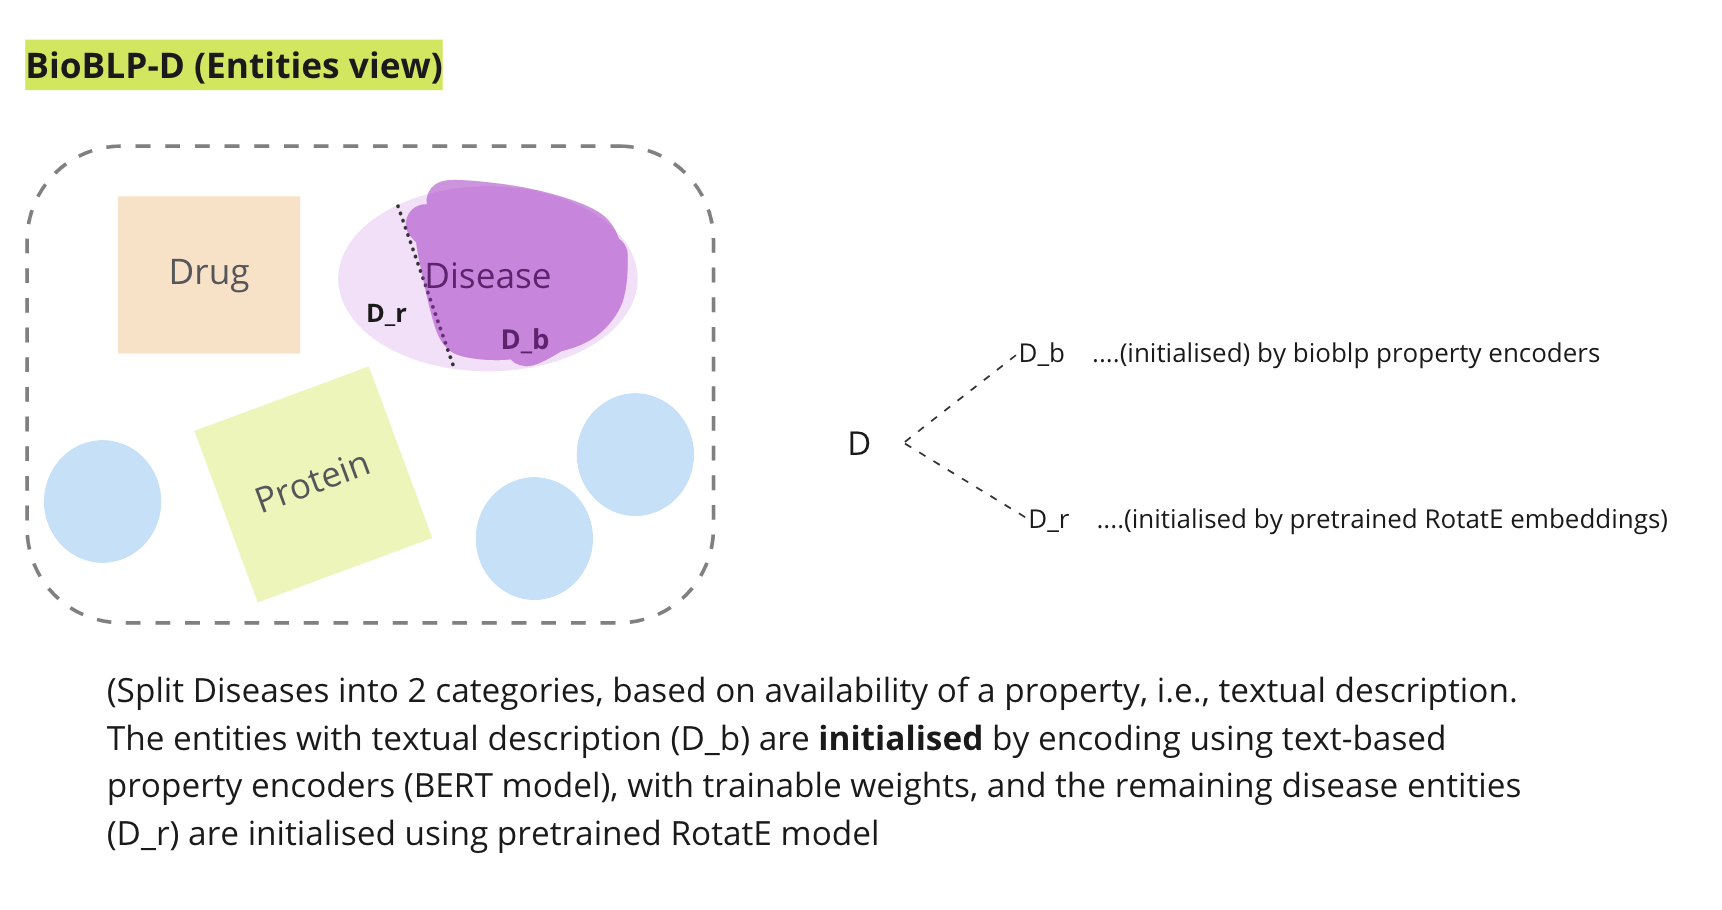

In [13]:
from IPython.display import Image
Image('data/imgs/eval_split_entity_view.png', width=600)

From stats below, we see that all biokgb entities surprisingly have a relation - > D_r is an empty set. -> This is because we used the name of disease as decription in places where it was missing


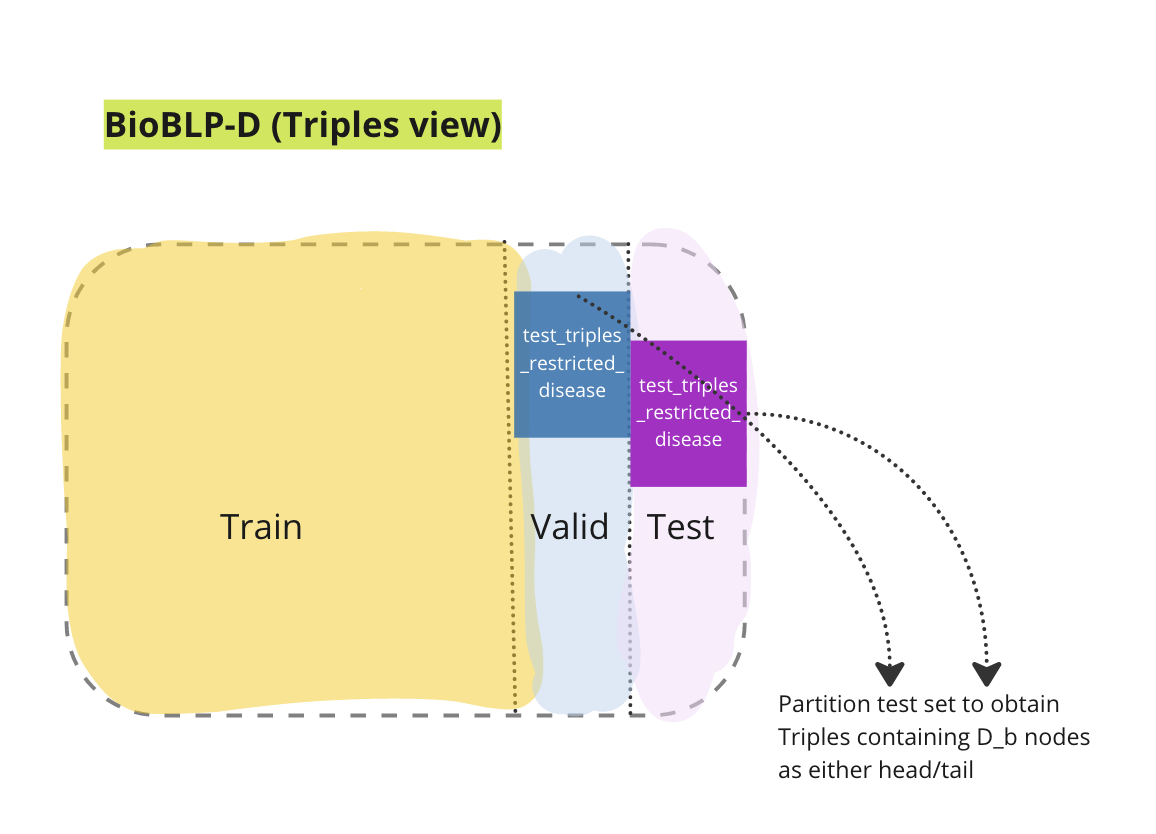

In [16]:
# The figure below demonstrates how we obtain the various test sets
Image('data/imgs/eval_split_triples_view.png', width=500)

In [28]:
ENTITY_TYPE_W_ATTR_ENCODE = 'protein'

{'disease': PosixPath('../data/biokgb/properties/biokg.metadata.disease.tsv'),
 'protein': PosixPath('../data/biokgb/properties/biokg.metadata.protein.tsv')}

In [15]:
from nb_utils.eval_utils import create_entity_attr_aware_test_sets
test_triples_incl_ent_prop, test_triples_excl_ent_prop= create_entity_attr_aware_test_sets(entity_type_w_attribute=PROTEIN,
                                   graph_cfg=graph_cfg,
                                   train=train,
                                   test=test)
                                   

# protein entities in larger biokg (pre-benchmark removal): 122902
# protein entities for which we have attributes: 121988


Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [ ]:
train.relation_to_id

{'COMPLEX_IN_PATHWAY': 0,
 'COMPLEX_TOP_LEVEL_PATHWAY': 1,
 'DDI': 2,
 'DISEASE_GENETIC_DISORDER': 3,
 'DISEASE_PATHWAY_ASSOCIATION': 4,
 'DPI': 5,
 'DRUG_CARRIER': 6,
 'DRUG_DISEASE_ASSOCIATION': 7,
 'DRUG_ENZYME': 8,
 'DRUG_PATHWAY_ASSOCIATION': 9,
 'DRUG_TARGET': 10,
 'DRUG_TRANSPORTER': 11,
 'MEMBER_OF_COMPLEX': 12,
 'PPI': 13,
 'PROTEIN_DISEASE_ASSOCIATION': 14,
 'PROTEIN_PATHWAY_ASSOCIATION': 15,
 'RELATED_GENETIC_DISORDER': 16}

In [19]:
prot_assoc_rel_names = ['MEMBER_OF_COMPLEX', 'PROTEIN_PATHWAY_ASSOCIATION', 'PPI',      
                   'PROTEIN_DISEASE_ASSOCIATION', 'RELATED_GENETIC_DISORDER', 'DPI',
                   'DRUG_TARGET', 'DRUG_TRANSPORTER', 'DRUG_ENZYME', 'DRUG_CARRIER']

In [36]:
# relations containing proteins include -> UNWEILDY
#prot_assoc_rels = {rel:rel_id for rel, rel_id in train.relation_to_id.items() if 'PROTEIN' in rel or rel in ['PPI', 'DPI', 'MEMBER_OF_COMPLEX', 'DRUG_ENZYME', 'DRUG_TARGET']}
prot_assoc_rels = {rel:rel_id for rel, rel_id in train.relation_to_id.items() if rel in prot_assoc_rel_names}
prot_assoc_rels

{'DPI': 5,
 'DRUG_CARRIER': 6,
 'DRUG_ENZYME': 8,
 'DRUG_TARGET': 10,
 'DRUG_TRANSPORTER': 11,
 'MEMBER_OF_COMPLEX': 12,
 'PPI': 13,
 'PROTEIN_DISEASE_ASSOCIATION': 14,
 'PROTEIN_PATHWAY_ASSOCIATION': 15,
 'RELATED_GENETIC_DISORDER': 16}

In [37]:
# create set of triples
print(f"# triples originally in test: {test.num_triples}, valid: {valid.num_triples}")
print(f"# test triples with {ENTITY_TYPE_W_ATTRIBUTE} nodes: {test_triples_incl_ent_prop.num_triples}")
print(f"# test triples without {ENTITY_TYPE_W_ATTRIBUTE} nodes: {test_triples_excl_ent_prop.num_triples}")


# triples originally in test: 185227, valid: 185226
# test triples with protein nodes: 54064
# test triples without protein nodes: 131163


In [38]:
triples_dict = {
    TEST: test,
    VALID: valid,
    TRAIN: train,
    TEST_RESTRICTED_PROT: test_triples_incl_ent_prop,
    TEST_EXCLUDING_PROT: test_triples_excl_ent_prop,
    DUMMY: dummy, 
}

TEST_SET_LIST = [TEST_RESTRICTED_PROT, TEST_EXCLUDING_PROT, TEST, VALID]


# Evaluation

wandb logging

In [24]:
import wandb
wandb.login()

WANDB_ENTITY_DISCOVERYLAB = "discoverylab"
WANDB_PROJECT_NAME = "bioblp-jupyter-eval"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pmitra01 (discoverylab). Use `wandb login --relogin` to force relogin


sanity check logic for experiment run with wandb logging

In [55]:
def trial_func(x=1, y=2):
    print(x*y)
    return {'x': x, 'y':y}

#trial_func_kwargs = {"x": 1, "y": 2} 
#metrics = run_experiment('dummy-run', TEST, BIOBLP_D, trial_func, **trial_func_kwargs) 

## analyse effect of node degree?
1. compute a degree table for entities in train

In [27]:
training_df = pd.DataFrame(train.triples, columns=[COL_SOURCE, COL_EDGE, COL_TARGET])
training_df[:2]

Reconstructing all label-based triples. This is expensive and rarely needed.


,src,rel,tgt
0,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-1479277
1,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-1591211


In [28]:
# not a nec step, but to ease computation, let's restrict the triples to disease node containg triples
#training_df = training_df[training_df[COL_EDGE].isin(list(dis_assoc_rels.keys()))]
training_df.rel.value_counts()

DDI                            906535
PROTEIN_PATHWAY_ASSOCIATION    205871
PPI                             93643
PROTEIN_DISEASE_ASSOCIATION     89804
MEMBER_OF_COMPLEX               71035
DRUG_DISEASE_ASSOCIATION        53426
COMPLEX_IN_PATHWAY              19615
COMPLEX_TOP_LEVEL_PATHWAY       12488
DPI                              7860
DRUG_TARGET                      5714
DISEASE_GENETIC_DISORDER         4339
DRUG_PATHWAY_ASSOCIATION         4244
RELATED_GENETIC_DISORDER         3450
DISEASE_PATHWAY_ASSOCIATION      2945
DRUG_ENZYME                       528
DRUG_TRANSPORTER                  222
DRUG_CARRIER                       90
Name: rel, dtype: int64

In [29]:
node_train_degree_df = compute_node_degrees_in_out(training_df)
node_train_degree_dict = pd.Series(node_train_degree_df.degree.values,index=node_train_degree_df.ent).to_dict()

Now we attach the training node degrees against the disease entities in Test triples

In [40]:
# now bucket the test triples according to node degree
def retrieve_node_degree(node, node2degree_dict):
    return node2degree_dict.get(node, 0)

test_triples_ent_w_attr_df = pd.DataFrame(test_triples_incl_ent_prop.triples, columns=[COL_SOURCE, COL_EDGE, COL_TARGET])
test_triples_ent_w_attr_df["src_training_degree"] = test_triples_ent_w_attr_df[COL_SOURCE].apply(lambda x: retrieve_node_degree(x, node_train_degree_dict))
test_triples_ent_w_attr_df["tgt_training_degree"] = test_triples_ent_w_attr_df[COL_TARGET].apply(lambda x: retrieve_node_degree(x, node_train_degree_dict))
test_triples_ent_w_attr_df.head()

Reconstructing all label-based triples. This is expensive and rarely needed.


,src,rel,tgt,src_training_degree,tgt_training_degree
0,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-2029130,67.0,59.0
1,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-2038750,67.0,23.0
2,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-2454243,67.0,60.0
3,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-983670,67.0,35.0
4,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-983674,67.0,51.0


In [41]:
test_triples_ent_w_attr_df[test_triples_ent_w_attr_df[COL_EDGE]=='RELATED_GENETIC_DISORDER'][-5:]

,src,rel,tgt,src_training_degree,tgt_training_degree
53648,Q9Y5Z9,RELATED_GENETIC_DISORDER,MIM:121800,43.0,1.0
53662,Q9Y619,RELATED_GENETIC_DISORDER,MIM:238970,15.0,1.0
53667,Q9Y625,RELATED_GENETIC_DISORDER,MIM:258315,14.0,2.0
53688,Q9Y6C5,RELATED_GENETIC_DISORDER,MIM:109400,9.0,2.0
53756,Q9Y6N9,RELATED_GENETIC_DISORDER,MIM:602092,34.0,19.0


In [42]:
test_triples_ent_w_attr_df.rel.nunique()

10

In [43]:
rels_w_prot_as_tgt = ['DPI',
                      'DRUG_CARRIER'
                      'DRUG_ENZYME',
                      'DRUG_TARGET'
                      'DRUG_TRANSPORTER',
                     ]
rels_w_prot_as_src = ['MEMBER_OF_COMPLEX', 
                      'PPI',
                      'PROTEIN_DISEASE_ASSOCIATION'
                      'PROTEIN_PATHWAY_ASSOCIATION',
                      'RELATED_GENETIC_DISORDER',
                      
                     ]

In [44]:
test_triples_ent_w_attr_df[test_triples_ent_w_attr_df[COL_EDGE].isin(rels_w_prot_as_tgt)].tgt_training_degree.describe()

count    526.000000
mean      68.604563
std       77.053967
min        1.000000
25%       24.000000
50%       41.000000
75%       84.750000
max      409.000000
Name: tgt_training_degree, dtype: float64

In [45]:
test_triples_ent_w_attr_df[test_triples_ent_w_attr_df[COL_EDGE].isin(rels_w_prot_as_src)].src_training_degree.describe()

count    19031.000000
mean        76.604330
std         81.642176
min          1.000000
25%         22.000000
50%         49.000000
75%        100.000000
max        480.000000
Name: src_training_degree, dtype: float64

In [36]:
print(f"We have {19031-526}, or {(19031-526)/526*100}% more test triples with proteins occuring in source position than in tail position")

We have 18505, or 3518.060836501901% more test triples with proteins occuring in source position than in tail position


Triples with protein as src entity far outnumber triples with protein as tail entity. 


### average performance predicting the node which has an entity degree of x

Let's focus only relation types where proteins are the source, as these have more support in the train/test sets

In [46]:
NODE_ENDPOINT_TO_PREDICT = COL_SOURCE
print(f"node end point to predict, and evaluate performance on: {NODE_ENDPOINT_TO_PREDICT}")
print(f"Restricting analysis to relations where we predict {ENTITY_TYPE_W_ATTRIBUTE} as {NODE_ENDPOINT_TO_PREDICT}")

node end point to predict, and evaluate performance on: src
Restricting analysis to relations where we predict protein as src


In [47]:
# define relations restrictions to consider, based on which node endpoint position the LP performance is evaluated on
RESTRICTED_RELS_FOR_EVAL_BY_NODE_ENDPOINT_TYPE = { 
    COL_SOURCE: rels_w_prot_as_src,
    COL_TARGET: rels_w_prot_as_tgt
}


In [48]:
def create_test_df_subset_given_node_endpoint_type_to_predict(test_df, 
                                                              node_endpoint_to_predict,
                                                              restricted_rels_by_node_endpoint_type_dict):
    test_subset_df = test_df.loc[test_df[COL_EDGE].isin(restricted_rels_by_node_endpoint_type_dict.get(node_endpoint_to_predict))]
    return test_subset_df

def get_unique_endpoint_entities_in_testset_of_given_degree(test_df, degree, node_endpoint_type=None,):
#                                                           restricted_rels_by_node_endpoint_type_dict=None):
    if node_endpoint_type not in [COL_SOURCE, COL_TARGET]:
        raise ValueError(f"Invalid node end point type {node_endpoint_type}. Allowed values are '{COL_SOURCE}' and '{COL_TARGET}'")
    test_subset = test_df[test_df[f"{node_endpoint_type}_training_degree"]==degree]
    test_unique_ents = test_subset.tgt.unique()
    return test_unique_ents


test_triples_by_node_endpoint_to_predict = {
    node_endpoint: create_test_df_subset_given_node_endpoint_type_to_predict(
        test_df=test_triples_ent_w_attr_df, 
        node_endpoint_to_predict=node_endpoint,
        restricted_rels_by_node_endpoint_type_dict=RESTRICTED_RELS_FOR_EVAL_BY_NODE_ENDPOINT_TYPE
    ) for node_endpoint in [COL_SOURCE, COL_TARGET]
}

{node_endpoint: test_triples_by_node_endpoint_to_predict[node_endpoint].shape for node_endpoint in [COL_SOURCE, COL_TARGET]}

{'src': (19031, 5), 'tgt': (526, 5)}

In [49]:
unique_protein_tail_ents_in_test = get_unique_endpoint_entities_in_testset_of_given_degree(test_triples_by_node_endpoint_to_predict[NODE_ENDPOINT_TO_PREDICT], 
                                                                                           degree=1, node_endpoint_type=COL_SOURCE)
len(get_unique_endpoint_entities_in_testset_of_given_degree(test_triples_by_node_endpoint_to_predict[NODE_ENDPOINT_TO_PREDICT], 
                                                            degree=1, node_endpoint_type=NODE_ENDPOINT_TO_PREDICT))

16

In [51]:
test_triples_prot_as_src[:2]

,src,rel,tgt,src_training_degree,tgt_training_degree
0,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-2029130,67.0,59.0
1,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-2038750,67.0,23.0


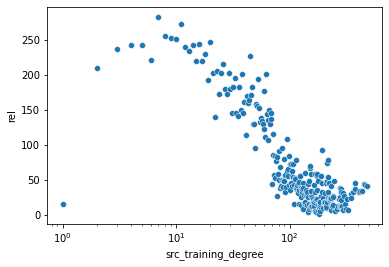

In [41]:
import seaborn as sns
test_triples_prot_as_src = test_triples_by_node_endpoint_to_predict[NODE_ENDPOINT_TO_PREDICT]
prot_degrees = test_triples_prot_as_src.groupby(['src_training_degree'])[COL_EDGE].agg('count').reset_index()
sns.scatterplot(data=prot_degrees, x='src_training_degree', y='rel')
plt.xscale('log')
#plt.yscale('log')

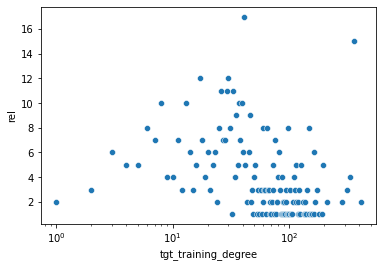

In [50]:
import seaborn as sns
test_triples_prot_as_src = test_triples_by_node_endpoint_to_predict[COL_TARGET]
prot_degrees = test_triples_prot_as_src.groupby(['tgt_training_degree'])[COL_EDGE].agg('count').reset_index()
sns.scatterplot(data=prot_degrees, x='tgt_training_degree', y='rel')
plt.xscale('log')
#plt.yscale('log')

<AxesSubplot:ylabel='tgt_training_degree'>

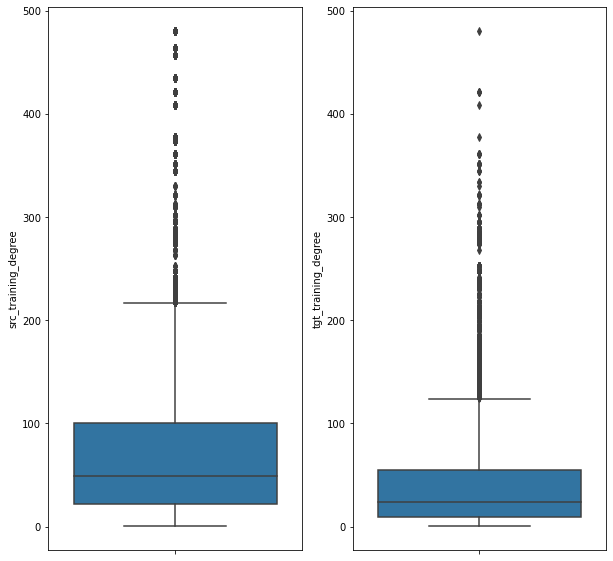

In [52]:
plot, ax = plt.subplots(1, 2, figsize=(10,10))
sns.boxplot(ax=ax[0], y=test_triples_prot_as_src['src_training_degree'])
sns.boxplot(ax=ax[1], y=test_triples_prot_as_src['tgt_training_degree'])

define logic

In [65]:
from pykeen.triples.triples_factory import TriplesFactory
train_triples=triples_dict.get(TRAIN)
valid_triples=triples_dict[VALID]

def compute_metrics_over_triples_with_ent_node_endpoint(model_id, 
                                                        test_triples_w_node_degree_df, 
                                                        test_set_slug,
                                                        node_endpoint_type,                                                           
                                                        train_triples,
                                                        valid_triples,
                                                        restricted_rels_by_node_endpoint_type_dict):
    col_node_degree = f"{node_endpoint_type}_training_degree" # if predicting head, this should be the 'src_training_degree'
    evaluator = RankBasedEvaluator(filtered=True)
    model_base_path = model_registry_paths.get(model_id)
    model = load_kge_model(model_base_path=model_base_path)
    print(f'loaded model from {str(model_base_path)}')
    additional_filter_triples = obtain_filtered_triples(test_type=test_set_slug,
                                                        train_triples=train_triples,
                                                        valid_triples=valid_triples
                                                       )
    
    test_triples_with_ent_node_endpoint_df = test_triples_w_node_degree_df.loc[test_triples_w_node_degree_df[COL_EDGE].isin(
        restricted_rels_by_node_endpoint_type_dict[NODE_ENDPOINT_TO_PREDICT])]
    ent_degree_values = test_triples_with_ent_node_endpoint_df[col_node_degree].unique()
    result_dicts = []
    
    for degree_val in tqdm(ent_degree_values): 
        df_subset = test_triples_with_ent_node_endpoint_df.loc[test_triples_with_ent_node_endpoint_df[col_node_degree]==degree_val][[COL_SOURCE, COL_EDGE, COL_TARGET]]
        triples_subset = df_subset.values
        triples_subset = TriplesFactory.from_labeled_triples(triples_subset, 
                                                             relation_to_id=train_triples.relation_to_id, 
                                                             entity_to_id=train_triples.entity_to_id)
        if triples_subset.num_triples > 0:
            subset_result = evaluator.evaluate(model,
                                               triples_subset.mapped_triples, 
                                               additional_filter_triples=additional_filter_triples,
                                               use_tqdm=False)
            result_dicts.append({'ent_degree': degree_val, 'results': subset_result, 'relation': 'All', 'count': triples_subset.num_triples})
    return result_dicts



In [70]:
def extract_relevant_metrics(metric_name, results_by_node_degree_dict):
    degrees = list(results_by_node_degree_dict.keys())
    metrics = []
    for deg, metric in results_by_node_degree_dict.items():
        metrics.append(metric[metric_name])
    return degrees, metrics
    
    
def plot_metric_vs_degree_scatterplot_single_model(model_id,
                                                   metric_name='hits_at_10', 
                                                   results_by_node_degree_dict=None, 
                                                   figsize=(7,7),
                                                   entity_type_examined=None,                                                   
                                                  ):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    degrees, metrics = extract_relevant_metrics(metric_name, results_by_node_degree_dict)   
    plot, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(ax = ax, x=degrees, y=metrics)
    plt.xscale('log')
    plt.ylabel(metric_name)
    plt.title(f'Average {metric_name} predicting {entity_type_examined} nodes Vs. {entity_type_examined} node degree | Model: {model_id}')
    plt.savefig(f'data/imgs/{metric_name}_node_degree_analysis-{model_id}-{timestr}')
    #return degrees, metrics
    
    
def plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_10', 
                                                   results_by_node_degree_dicts_combined=None,
                                                   entity_type_examined=None,
                                                  ):
    result_dfs = {}
    timestr = time.strftime("%Y%m%d-%H%M%S")
    for model_id, result_dict in results_by_node_degree_dicts_combined.items():
        degrees, metrics = extract_relevant_metrics(metric_name, result_dict)
        result_dfs[model_id] = pd.DataFrame(np.column_stack([degrees, metrics]), columns=['degree', 'metrics'], dtype=float)
    model_ids = result_dfs.keys()
    concatenated = pd.concat([result_dfs[model_id].assign(dataset=f'{model_id}') for model_id in model_ids])
    plot, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(ax=ax, data=concatenated, x='degree', y='metrics', hue='dataset')
    plt.xscale('log')
    plt.ylabel(metric_name)
    plt.title(f'Average {metric_name} predicting {entity_type_examined} nodes Vs. {entity_type_examined} node degree | Model: {list(model_ids)}')
    plt.savefig(f'data/imgs/{metric_name}_node_degree_analysis-{list(model_ids)}-{timestr}')

    #return degrees, metrics
    

#### predict on bioblp-p

In [55]:
MODEL_NAME_SLUG = BIOBLP_P
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")
results_by_node_degree_bioblpp = compute_metrics_over_triples_with_ent_node_endpoint(model_id=MODEL_ID,
                                                                                     test_triples_w_node_degree_df=test_triples_prot_as_src, 
                                                                                     test_set_slug=TEST_RESTRICTED_PROT,
                                                                                     node_endpoint_type=COL_SOURCE,
                                                                                     train_triples=triples_dict.get(TRAIN),
                                                                                     valid_triples=triples_dict.get(VALID),
                                                                                     restricted_rels_by_node_endpoint_type_dict=RESTRICTED_RELS_FOR_EVAL_BY_NODE_ENDPOINT_TYPE,
)

loaded model from /home/jovyan/workbench-shared-folder/bioblp/models/bioblpp-cttc3ucm


100%|██████████| 253/253 [1:04:19<00:00, 15.26s/it]


In [57]:
results_by_node_degree_dicts_bioblpp = {}
for result in results_by_node_degree_bioblpp:
         results_by_node_degree_dicts_bioblpp[result['ent_degree']] = make_results_dict_all_rel(result['results'],
                                                                                relation=result['relation'],
                                                                                relation_count=result['count'],
                                                                                triple_endpoint='tail',
                                                                                metric_type='realistic'
                                                                               )
#results_by_node_degree_dicts_bioblpd

In [59]:
results_by_node_degree_bioblpp = results_by_node_degree_bioblpd

In [58]:

WRITE_TO_FILE=True
if WRITE_TO_FILE:
    timestr = time.strftime("%Y%m%d-%H%M%S")
    # eval_out_dir = Path(f"./metrics/{MODEL_ID}")
    eval_out_dir.joinpath(timestr)
    eval_out_dir.mkdir(exist_ok=True, parents=True)
    eval_out_file = eval_out_dir.joinpath("node-degree-eval.json")
    print(f"Writing results to {str(eval_out_file)}")
    with open(eval_out_file, "w+") as f:
        json.dump(results_by_node_degree_dicts_bioblpp, f)


Writing results to metrics/bioblpp-cttc3ucm/node-degree-eval.json


### predict on rotate

In [163]:
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")
results_by_node_degree_rotate = compute_metrics_over_triples_with_ent_node_endpoint(model_id=MODEL_ID,
                                                                                     test_triples_w_node_degree_df=test_triples_prot_as_src, 
                                                                                     test_set_slug=TEST_RESTRICTED_PROT,
                                                                                     node_endpoint_type=COL_SOURCE,
                                                                                     train_triples=triples_dict.get(TRAIN),
                                                                                     valid_triples=triples_dict.get(VALID),
                                                                                     restricted_rels_by_node_endpoint_type_dict=RESTRICTED_RELS_FOR_EVAL_BY_NODE_ENDPOINT_TYPE,
)

loaded model from /home/jovyan/workbench-shared-folder/bioblp/models/rotate-otxtubeb


100%|██████████| 253/253 [1:05:45<00:00, 15.59s/it]


In [165]:
results_by_node_degree_dicts_rotate = {}
for result in results_by_node_degree_rotate:
         results_by_node_degree_dicts_rotate[result['ent_degree']] = make_results_dict_all_rel(result['results'],
                                                                                relation=result['relation'],
                                                                                relation_count=result['count'],
                                                                                triple_endpoint='tail',
                                                                                metric_type='realistic'
                                                                               )
#results_by_node_degree_dicts_bioblpd

In [166]:
WRITE_TO_FILE=True
if WRITE_TO_FILE:
    timestr = time.strftime("%Y%m%d-%H%M%S")
    # eval_out_dir = Path(f"./metrics/{MODEL_ID}")
    eval_out_dir = eval_out_dir.joinpath(timestr)
    eval_out_dir.mkdir(exist_ok=True, parents=True)
    eval_out_file = eval_out_dir.joinpath("node-degree-eval.json")
    print(f"Writing results to {str(eval_out_file)}")
    with open(eval_out_file, "w+") as f:
        json.dump(results_by_node_degree_dicts_rotate, f)


Writing results to metrics/rotate-otxtubeb/node-degree-eval.json


In [60]:
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

with open(eval_out_dir.joinpath('node-degree-eval.json'), 'r') as f:
    results_by_node_degree_dicts_rotate = json.load(f)


### Plots V2 - (improved 17/03) - Plotting the difference in LP scores by RotatE and BioBLP-X

In [55]:
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

with open(eval_out_dir.joinpath('node-degree-eval.json'), 'r') as f:
    results_by_node_degree_dicts_rotate = json.load(f)

    
MODEL_NAME_SLUG = BIOBLP_P
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}/20230321-134444")
#eval_out_dir = Path(f"/metrics/{MODEL_ID}")
with open(eval_out_dir.joinpath('node-degree-eval.json'), 'r') as f:
    results_by_node_degree_dicts_bioblpp = json.load(f)


In [56]:
rotate_df = pd.DataFrame.from_dict(results_by_node_degree_dicts_rotate, orient='index')
rotate_df = rotate_df.reset_index().rename(columns={'index':'degree'})
rotate_df = rotate_df.astype({'degree':'float'})

bioblpp_df = pd.DataFrame.from_dict(results_by_node_degree_dicts_bioblpp, orient='index')
bioblpp_df = bioblpp_df.reset_index().rename(columns={'index':'degree'})
bioblpp_df = bioblpp_df.astype({'degree':'float'})


In [57]:
merged_df = rotate_df.merge(bioblpp_df, how='inner', on='degree', suffixes=['_rotate', '_bioblpp'])
merged_df.drop(columns=['Relation_bioblpp', 'Relation_rotate', 'Count_bioblpp'], inplace=True)
merged_df = merged_df.astype({'degree':'float'})
merged_df = merged_df.rename(columns={"Count_rotate":"count"})
merged_df[:3]

,degree,count,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,hits_at_1_bioblpp,hits_at_3_bioblpp,hits_at_5_bioblpp,hits_at_10_bioblpp,inverse_harmonic_mean_rank_bioblpp
0,67.0,129,0.542636,0.612403,0.627907,0.658915,0.591018,0.310078,0.410853,0.418605,0.441860,0.364500
1,61.0,111,0.342342,0.423423,0.432432,0.495495,0.391640,0.144144,0.189189,0.189189,0.207207,0.172978
2,51.0,158,0.265823,0.348101,0.411392,0.500000,0.339453,0.056962,0.075949,0.113924,0.170886,0.088043


In [58]:
merged_df['num_unique_ents'] = merged_df['degree'].apply(
    lambda x: len(get_unique_endpoint_entities_in_testset_of_given_degree(test_triples_prot_as_src, 
                                                                          degree=x, 
                                                                          node_endpoint_type=NODE_ENDPOINT_TO_PREDICT)))

In [59]:
min_c, max_c, mean_c, std_c = merged_df['count'].min(), merged_df['count'].max(), merged_df['count'].mean(), merged_df['count'].std()
merged_df['proportion'] = (merged_df['count']-min_c)/(max_c-min_c)
merged_df.proportion.describe()

count    253.000000
mean       0.263196
std        0.253267
min        0.000000
25%        0.078014
50%        0.156028
75%        0.429078
max        1.000000
Name: proportion, dtype: float64

In [60]:
merged_df[merged_df['degree']==1.0]

,degree,count,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,hits_at_1_bioblpp,hits_at_3_bioblpp,hits_at_5_bioblpp,hits_at_10_bioblpp,inverse_harmonic_mean_rank_bioblpp,num_unique_ents,proportion
23,1.0,16,0.0,0.0,0.0,0.0,0.00828,0.0,0.0,0.0,0.0,0.000085,2,0.053191


In [61]:
from nb_utils.eval_utils import EVAL_METRICS_SHORTLIST
for metric in EVAL_METRICS_SHORTLIST:
    merged_df[metric] = merged_df[f'{metric}_rotate'] - merged_df[f'{metric}_bioblpp']

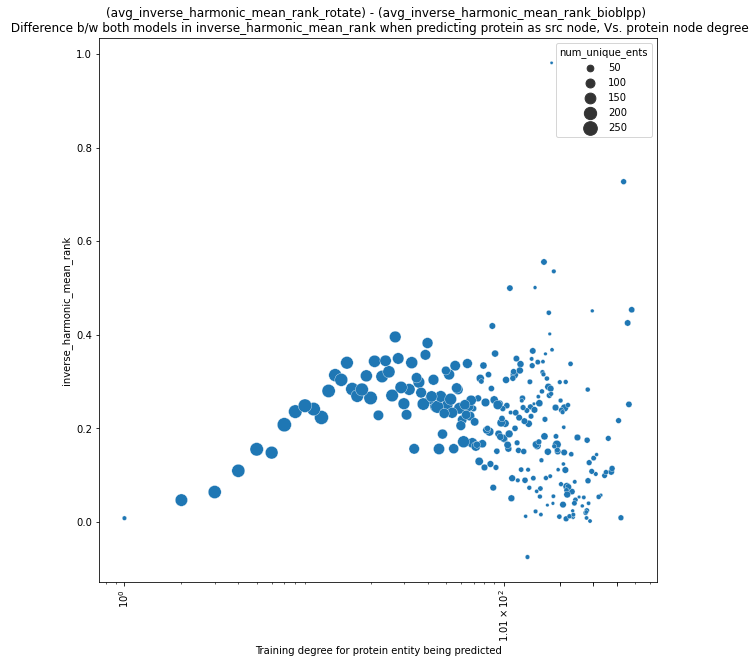

In [62]:
import matplotlib.ticker as ticker
metric_name='inverse_harmonic_mean_rank'
#metric_name='hits_at_10'
degrees, metrics, counts, props, num_unique_ents = merged_df['degree'], merged_df[metric_name], merged_df['count'] , merged_df['proportion'], merged_df['num_unique_ents']
plot, ax = plt.subplots(figsize=(10,10))
sns.color_palette("flare", as_cmap=True)
#s_square = [n*n for n in props] 
s_square = [n*n for n in num_unique_ents] 
plot_ = sns.scatterplot(ax = ax, x=degrees, y=metrics, size=num_unique_ents, sizes=(10,200))
plt.xscale('log')
#ax.legend(title='# unique entities')
plt.ylabel(metric_name)
plt.xlabel(f'Training degree for {ENTITY_TYPE_W_ATTRIBUTE} entity being predicted')
plt.xticks(degrees, rotation='vertical')

plot_.xaxis.set_major_locator(ticker.IndexLocator(100, 0))

plt.title(f'(avg_{metric_name}_rotate) - (avg_{metric_name}_bioblpp) \n Difference b/w both models in {metric_name} when predicting {ENTITY_TYPE_W_ATTRIBUTE} as {NODE_ENDPOINT_TO_PREDICT} node, Vs. {ENTITY_TYPE_W_ATTRIBUTE} node degree')
plt.savefig(f'data/imgs/{metric_name}_node_degree_analysis-{MODEL_ID_bioblpp}-{MODEL_ID_rotate}')

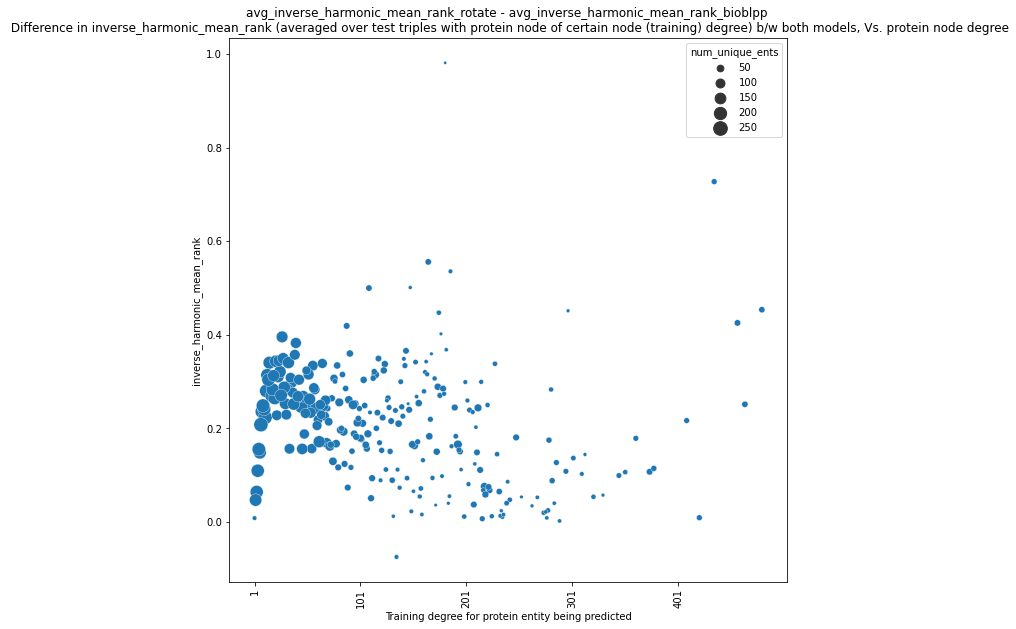

In [58]:
import matplotlib.ticker as ticker
metric_name='inverse_harmonic_mean_rank'
#metric_name='hits_at_1'
degrees, metrics, counts, props, num_unique_ents = merged_df['degree'], merged_df[metric_name], merged_df['count'] , merged_df['proportion'], merged_df['num_unique_ents']
plot, ax = plt.subplots(figsize=(10,10))
sns.color_palette("flare", as_cmap=True)
#s_square = [n*n for n in props] 
s_square = [n*n for n in num_unique_ents] 
plot_ = sns.scatterplot(ax = ax, x=degrees, y=metrics, size=num_unique_ents, sizes=(10,200))
#plt.xscale('log')
#ax.legend(title='# unique entities')
plt.ylabel(metric_name)
plt.xlabel(f'Training degree for {ENTITY_TYPE_W_ATTRIBUTE} entity being predicted')
plt.xticks(degrees, rotation='vertical')

plot_.xaxis.set_major_locator(ticker.IndexLocator(100, 0))

plt.title(f'avg_{metric_name}_rotate - avg_{metric_name}_bioblpp \n Difference in {metric_name} (averaged over test triples with {ENTITY_TYPE_W_ATTRIBUTE} node of certain node (training) degree) b/w both models, Vs. {ENTITY_TYPE_W_ATTRIBUTE} node degree')
plt.savefig(f'data/imgs/{metric_name}_node_degree_analysis')

NameError: name 'cmap' is not defined

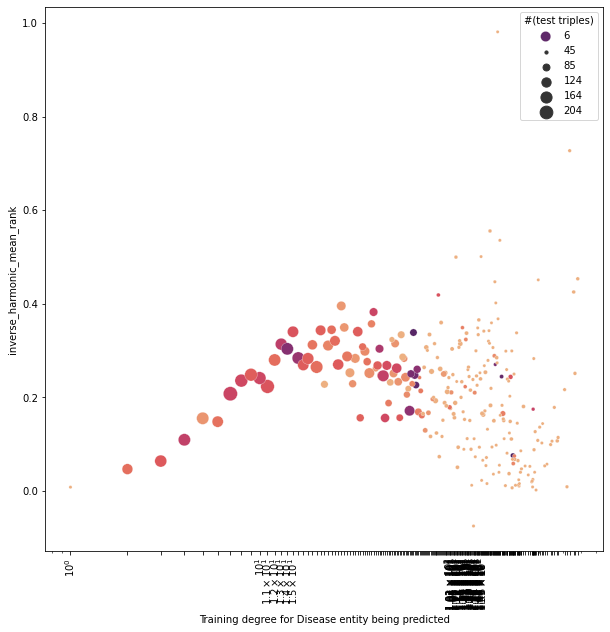

In [87]:
import matplotlib.ticker as ticker
metric_name='inverse_harmonic_mean_rank'
#metric_name='hits_at_10'
degrees, metrics, counts, props, num_unique_ents = merged_df['degree'], merged_df[metric_name], merged_df['count'] , merged_df['proportion'], merged_df['count']/merged_df['num_unique_ents']
plot, ax = plt.subplots(figsize=(10,10))
sns.color_palette("flare", as_cmap=True)
s_linear = [n*n for n in props] 
plot_ = sns.scatterplot(ax = ax, x=degrees, y=metrics, size=s_linear, sizes=(10,200), c=num_unique_ents, cmap='flare')
plt.xscale('log')
ax.legend(title='#(test triples)', labels = ['6', '45', '85', '124', '164', '204'])
plt.ylabel(metric_name)
plt.xlabel('Training degree for Disease entity being predicted')
plt.xticks(degrees, rotation='vertical')
#plot_.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)

norm = plt.Normalize(num_unique_ents.min(), num_unique_ents.max())
cbar = ax.figure.colorbar(plt.cm.ScalarMappable(norm=norm,
                                                cmap=cmap),
                          #ticks=np.arange(num_unique_ents.min(), num_unique_ents.max() + 1),
                          label=r'# test_triples per unique disease')
d
plot_.xaxis.set_major_locator(ticker.IndexLocator(100, 0))

plt.title(f'avg_{metric_name}_rotate - avg_{metric_name}_bioblpp \n Difference in {metric_name} (averaged over test triples with {ENTITY_TYPE_W_ATTRIBUTE} node of certain node (training) degree) b/w both models, Vs. disease node degree')
plt.savefig(f'data/imgs/{metric_name}_node_degree_analysis')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


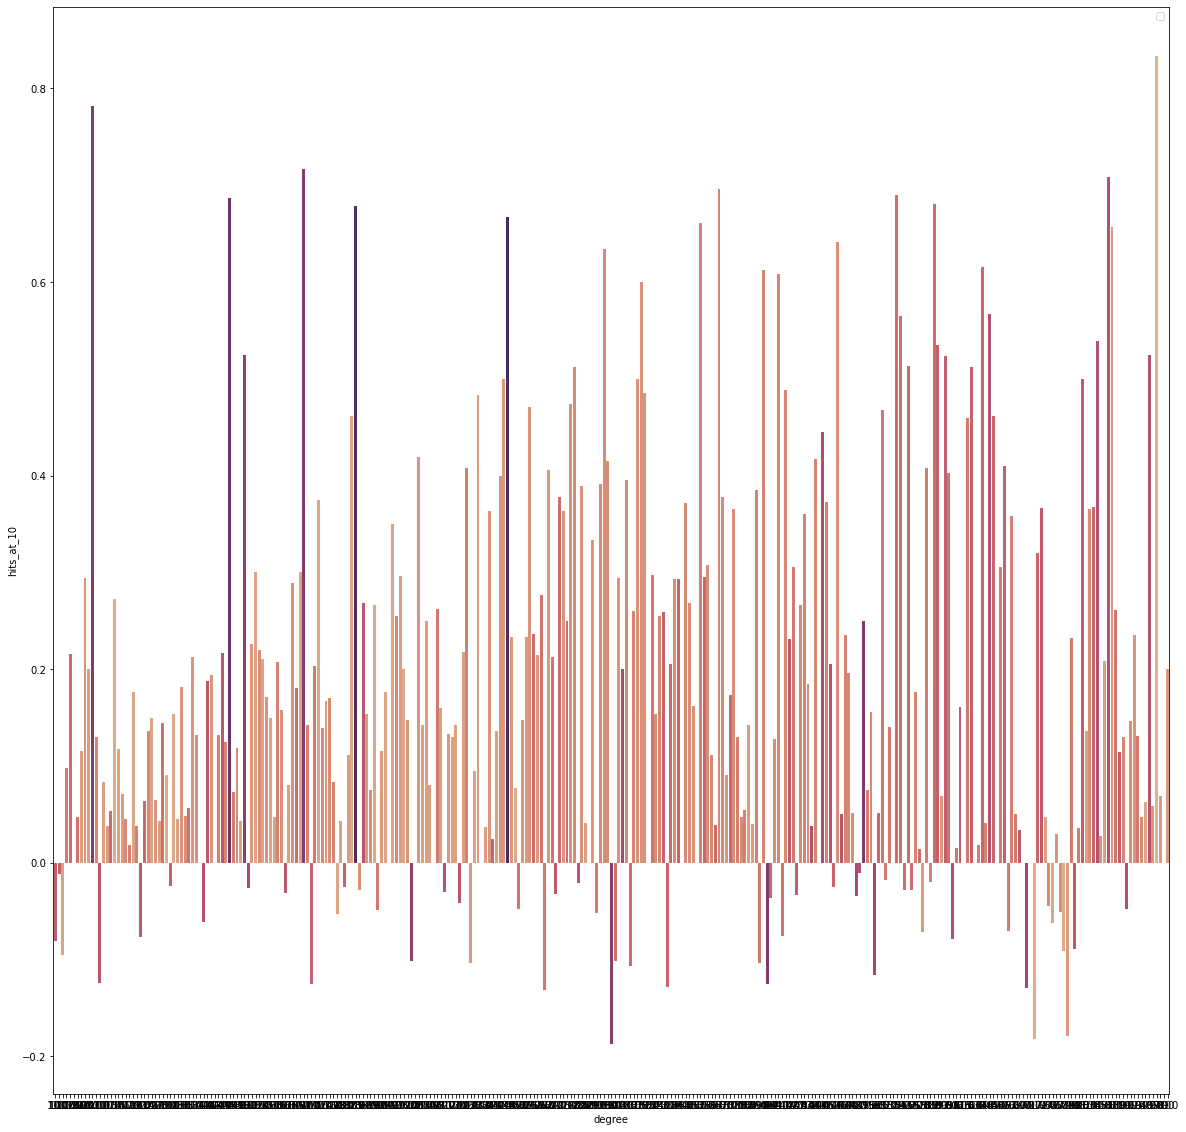

In [187]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)
plot, ax = plt.subplots(figsize=(20,20))
sns.barplot(ax=ax, x=degrees, y=metrics, palette=colors_from_values(props, "flare"))
plt.legend()

### Plots V1 - Separate series plotted for BioBLP-D and RotatE

load from file

In [68]:
ENTITY_TYPE_W_ATTRIBUTE = 'Protein'
MODEL_NAME_SLUG = BIOBLP_D
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")
LOAD_FROM_FILE=False
if LOAD_FROM_FILE:
    with open(eval_out_dir.joinpath('node-degree-eval-new.json'), 'r') as f:
        results_by_node_degree_dicts_bioblpd = json.load(f)


In [69]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_1',
                                               model_id=MODELS.get(ROTATE),
                                               results_by_node_degree_dict=results_by_node_degree_dicts_rotate,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE
                                              )

TypeError: strftime() takes at least 1 argument (0 given)

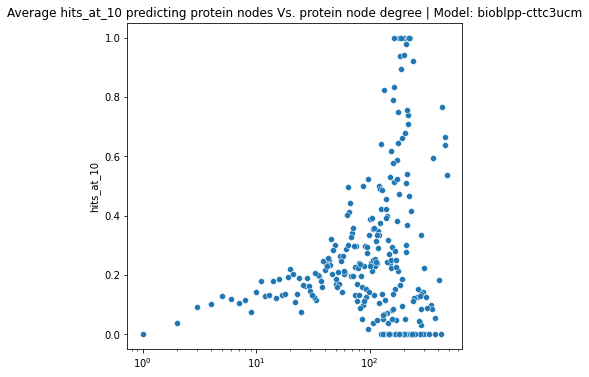

In [91]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_10', 
                                               model_id=MODELS.get(BIOBLP_P),
                                               results_by_node_degree_dict=results_by_node_degree_dicts_bioblpp,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE,
                                              figsize=(6,6))

In [48]:
tags = {"model_name": MODEL_ID_bioblpp,
        "study_name": 'node_degree_trend',
        "test_set_type": TEST_RESTRICTED_DIS}
run = setup_wandb_result_tracker(**tags, project_name='bioblp-jupyter-trial', wandb_entity='discoverylab')

In [49]:
metric_name = "hits_at_1"
degrees, metrics = extract_relevant_metrics(metric_name, results_by_node_degree_dicts_bioblpdx)
data = [[x, y] for (x, y) in zip(degrees, metrics)]
table = wandb.Table(data=data, columns = ["degrees", "metrics"])
wandb.log({f"bioblpd-{metric_name}_node_degree" : wandb.plot.scatter(table, "degrees", "metrics")})


#### RotatE

All plots below look quite similar!

load from file

In [22]:
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

with open(eval_out_dir.joinpath('node-degree-eval-new.json'), 'r') as f:
    results_by_node_degree_dicts_rotate = json.load(f)


In [76]:
from nb_utils.eval_utils import plot_metric_vs_degree_scatterplot_single_model
from nb_utils.eval_utils import plot_metric_vs_degree_scatterplot_multi_models


In [86]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpp"

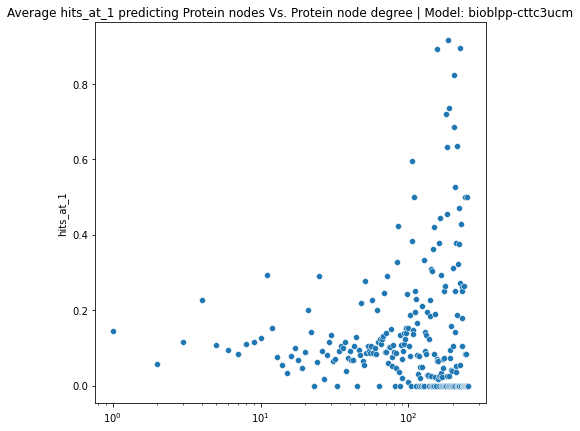

In [91]:
metric_name='hits_at_1'
MODEL_ID_SLUG = BIOBLP_P
plot_metric_vs_degree_scatterplot_single_model(metric_name=metric_name, 
                                               model_id=MODELS.get(MODEL_ID_SLUG),
                                               results_by_node_degree_dict=results_by_node_degree_dicts_bioblpp,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE,
                                              eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)
#plt.savefig(f'data/imgs/{MODEL_ID}-{metric_name}-{ENTITY_TYPE_W_ATTRIBUTE}_node_degree_analysis')

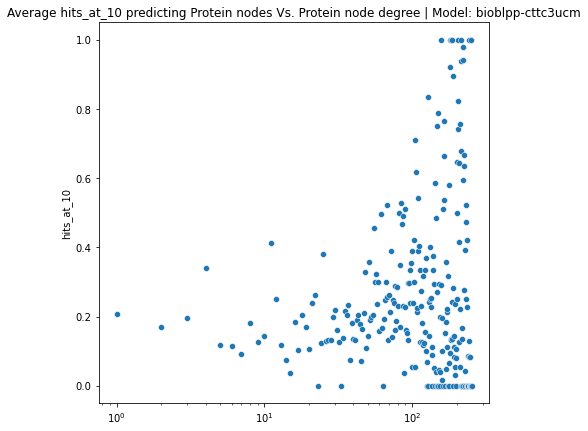

In [92]:
metric_name='hits_at_10'
MODEL_ID_SLUG = BIOBLP_P
plot_metric_vs_degree_scatterplot_single_model(metric_name=metric_name, 
                                               model_id=MODELS.get(MODEL_ID_SLUG),
                                               eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS,
                                               results_by_node_degree_dict=results_by_node_degree_dicts_bioblpp,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE)
#plt.savefig(f'data/imgs/{MODEL_ID}-{metric_name}-{ENTITY_TYPE_W_ATTRIBUTE}_node_degree_analysis')

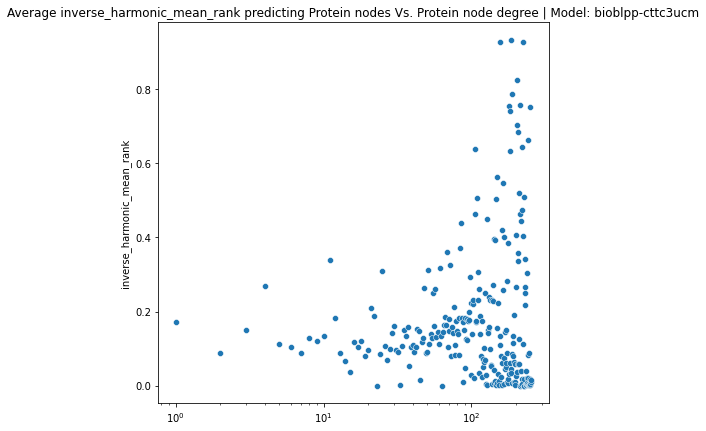

In [93]:
from nb_utils.eval_utils import INVERSE_HARMONIC_MEAN_RANK
MODEL_ID_SLUG = BIOBLP_P
metric_name=INVERSE_HARMONIC_MEAN_RANK
plot_metric_vs_degree_scatterplot_single_model(metric_name=metric_name, 
                                               model_id=MODELS.get(MODEL_ID_SLUG),
                                               results_by_node_degree_dict=results_by_node_degree_dicts_bioblpp,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE,
                                               eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS,
                                              )


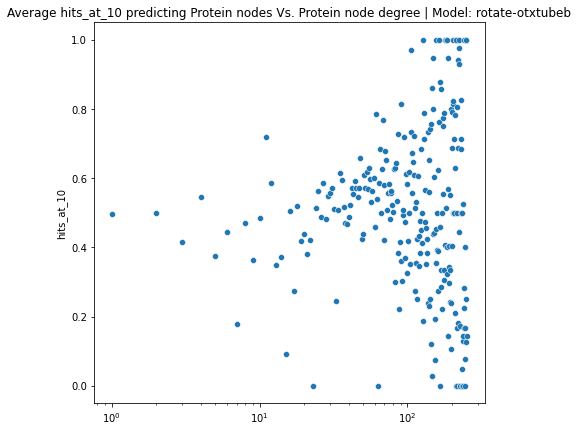

In [89]:
metric_name='hits_at_10'
MODEL_ID_SLUG = ROTATE
plot_metric_vs_degree_scatterplot_single_model(metric_name=metric_name, 
                                               model_id=MODELS.get(MODEL_ID_SLUG),
                                               eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS,
                                               results_by_node_degree_dict=results_by_node_degree_dicts_rotate,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE)
#plt.savefig(f'data/imgs/{MODEL_ID}-{metric_name}-{ENTITY_TYPE_W_ATTRIBUTE}_node_degree_analysis')

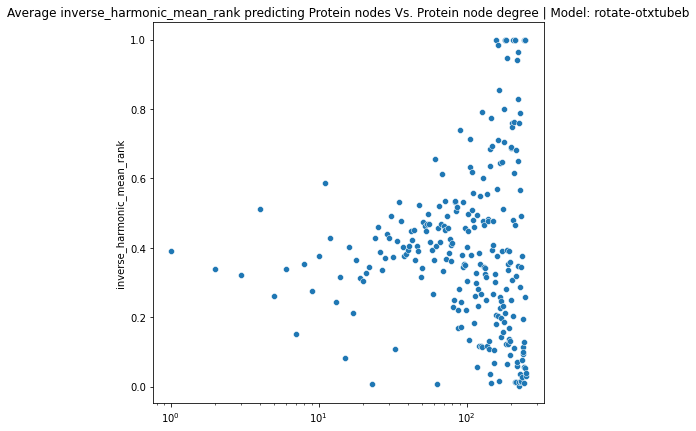

In [90]:
from nb_utils.eval_utils import INVERSE_HARMONIC_MEAN_RANK
MODEL_ID_SLUG = ROTATE
metric_name=INVERSE_HARMONIC_MEAN_RANK
plot_metric_vs_degree_scatterplot_single_model(metric_name=metric_name, 
                                               model_id=MODELS.get(MODEL_ID_SLUG),
                                               results_by_node_degree_dict=results_by_node_degree_dicts_rotate,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE,
                                               eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS,
                                              )


### combine into one graph

In [53]:
import matplotlib.pyplot as plt
img_outdir = Path('./data/imgs/')
def plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_10', 
                                                   results_by_node_degree_dicts_combined=None,
                                                   img_outdir=img_outdir):
    result_dfs = {}
    for model_id, result_dict in results_by_node_degree_dicts_combined.items():
        degrees, metrics = extract_relevant_metrics(metric_name, result_dict)
        result_dfs[model_id] = pd.DataFrame(np.column_stack([degrees, metrics]), columns=['degree', 'metrics'], dtype=float)
    model_ids = list(result_dfs.keys())
    if len(model_ids)>2:
        raise ValueError("This function currently handles results from 2 models. Amend logic to handle >2 models")
    
    concatenated = pd.concat([result_dfs[model_ids[0]].assign(dataset=f'{model_ids[0]}'),
                              result_dfs[model_ids[1]].assign(dataset=f'{model_ids[1]}')])
    plot, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(ax=ax, data=concatenated, x='degree', y='metrics', hue='dataset', style='dataset')
    plt.xscale('log')
    plt.ylabel(metric_name)
    plt.title(f'Average {metric_name} predicting disease nodes Vs. {ENTITY_TYPE_W_ATTRIBUTE} node degree | 2 Model Comparison')
    #return degrees, metr ics
    plt.savefig(img_outdir.joinpath(f"{metric_name}_vs_node_degree_{model_ids[0]}_and_{model_ids[1]}.png"))
    return concatenated

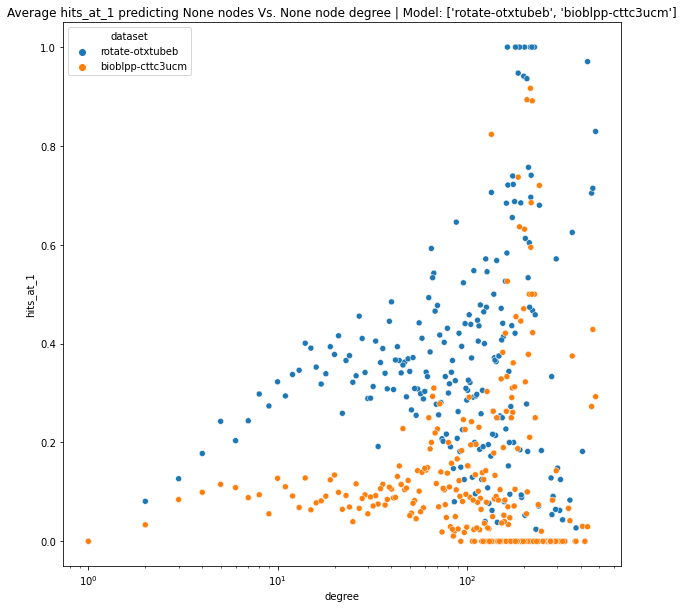

In [114]:
model_result_dicts = {MODEL_ID_rotate: results_by_node_degree_dicts_rotate,
                     MODEL_ID_bioblpp: results_by_node_degree_dicts_bioblpp}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_1', results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


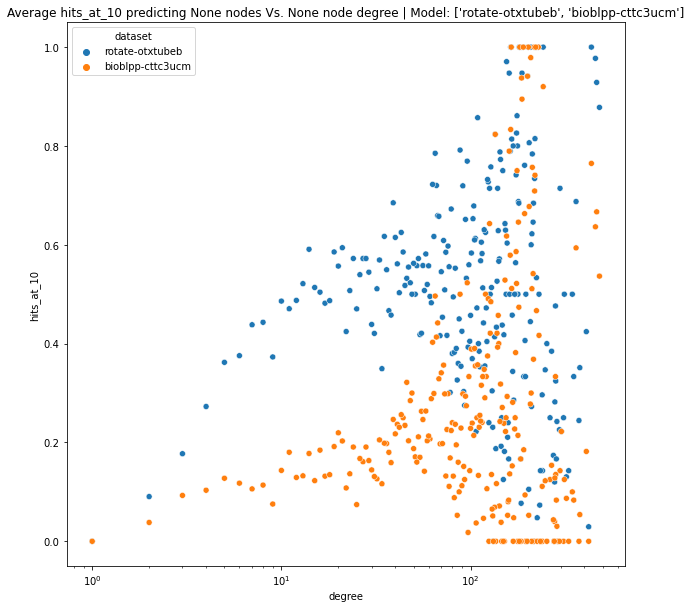

In [113]:
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_10', results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


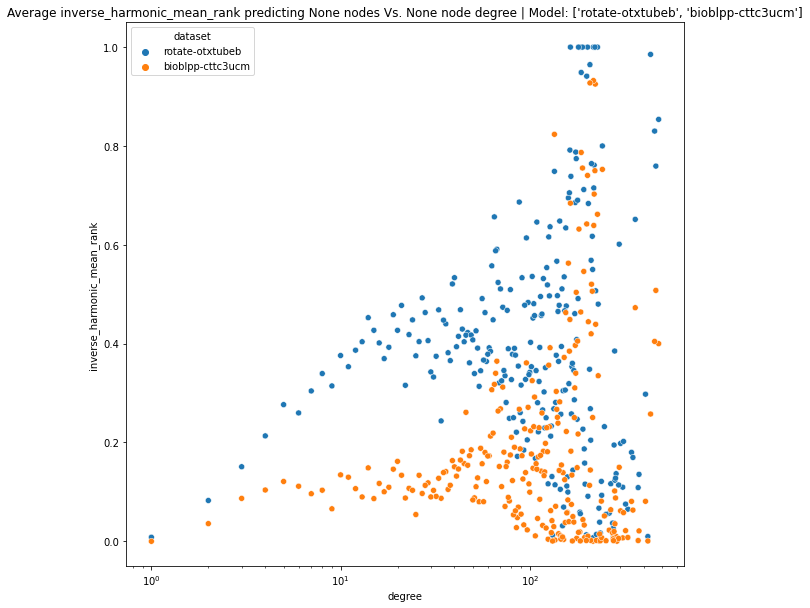

In [112]:
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='inverse_harmonic_mean_rank', results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


In [98]:
wandb.login()

True

In [99]:
tags = {"model_name": MODELS.get(BIOBLP_P),
        "study_name": 'node_degree_trends_both_models_combined',
        "test_set_type": TEST_RESTRICTED_PROT}
run = setup_wandb_result_tracker(**tags, 
                                 notes=f'combined lp results for {MODELS.get(BIOBLP_P)} and {MODELS.get(ROTATE)}', 
                                 project_name='bioblp-jupyter-trial',
                                 wandb_entity='discoverylab')

Save custom plots to Weights and biases

In [117]:
!ls {EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}

20230324-173105-hits_at_1_node_degree_analysis-rotate-otxtubeb-20230324-173105.png
20230324-173137-hits_at_10_node_degree_analysis-rotate-otxtubeb-20230324-173137.png
20230324-173248-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-20230324-173248.png
20230324-173341-hits_at_1_node_degree_analysis-bioblpp-cttc3ucm-20230324-173341.png
20230324-173404-hits_at_10_node_degree_analysis-bioblpp-cttc3ucm-20230324-173404.png
20230324-173426-inverse_harmonic_mean_rank_node_degree_analysis-bioblpp-cttc3ucm-20230324-173426.png
20230324-174518-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png
20230324-174536-hits_at_10_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png
20230324-174539-hits_at_1_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png


In [120]:
#degree_analysis_hits_at_1_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174539-hits_at_1_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"
#degree_analysis_hits_at_10_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174536-hits_at_10_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"
degree_analysis_mrr_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174518-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"

wandb.log({"hits@1_combined_bioblpd_rotate": wandb.Image(degree_analysis_hits_at_1_rotate_and_bioblpp_path)})
wandb.log({"hits@10_combined_bioblpd_rotate": wandb.Image(degree_analysis_hits_at_10_rotate_and_bioblpp_path)})
wandb.log({"mrr_combined_bioblpd_rotate": wandb.Image(degree_analysis_mrr_rotate_and_bioblpp_path)})

In [ ]:
todo - change for bioblpp -> add the new diff plots!
todo - compare micro averages to sanity check

In [187]:
#degree_analysis_hits_at_10_bioblpd_path = "./data/imgs/node_analysis_hits_at_10_bioblpd.png"
#degree_analysis_hits_at_1_bioblpd_path = "./data/imgs/node_analysis_hits_at_1_bioblpd.png"

#wandb.log({"hits@10_bioblpd": wandb.Image(degree_analysis_hits_at_10_bioblpd_path)})
#wandb.log({"hits@1_bioblpd": wandb.Image(degree_analysis_hits_at_1_bioblpd_path)})

## 

In [188]:
test_entity_split_by_disease_descr_path = "./data/imgs/eval_split_entity_view.png"
test_triples_split_by_disease_descr_path = "./data/imgs/eval_split_triples_view.png"
wandb.log({"Split test set entities conditioned on entity having properties with text modality": wandb.Image(test_entity_split_by_disease_descr_path)})
wandb.log({"Split test set triples conditioned on having node entities with properties of text modality": wandb.Image(test_triples_split_by_disease_descr_path)})

In [206]:
degree_analysis_hits_at_10_rotate_path = "./data/imgs/node_analysis_hits_at_10_rotate.png"
degree_analysis_hits_at_1_rotate_path = "./data/imgs/node_analysis_hits_at_1_rotate.png"

wandb.log({"hits@10_rotate": wandb.Image(degree_analysis_hits_at_10_rotate_path)})
wandb.log({"hits@1_rotate": wandb.Image(degree_analysis_hits_at_1_rotate_path)})

## archived

### previous stuff

How do MRR, H@k, and AMR correlate?

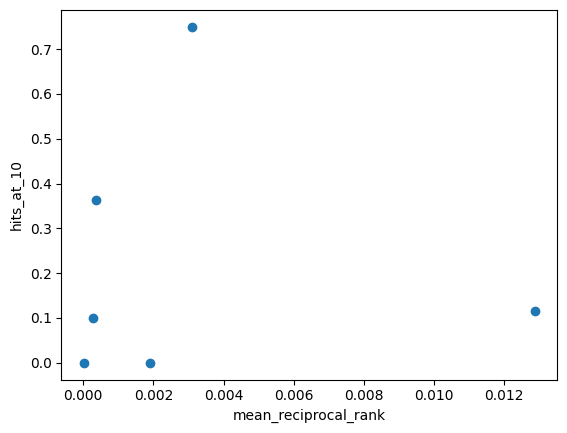

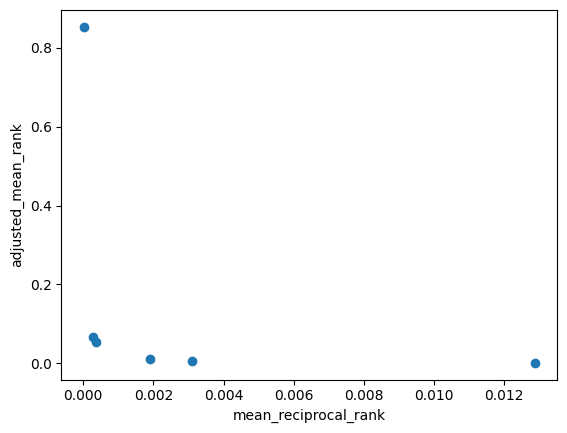

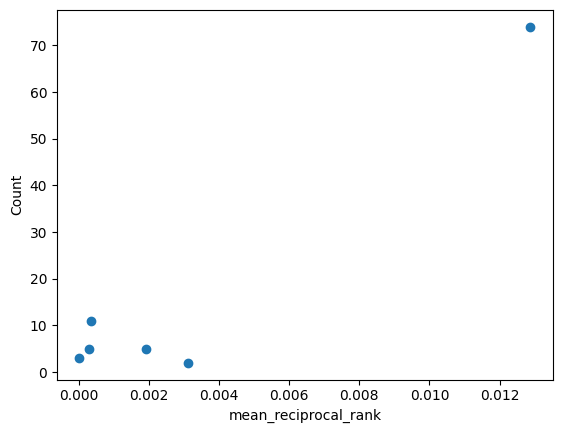

In [32]:
def plot_metric_pair(results_df, metric_1: str, metric_2: str):
    """Make a scatter plot with one link prediction metric in each axis."""
    plt.figure()
    plt.scatter(results_df[metric_1], results_df[metric_2])
    plt.xlabel(metric_1)
    plt.ylabel(metric_2)

plot_metric_pair(results_df, 'mean_reciprocal_rank', 'hits_at_10')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'adjusted_mean_rank')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'Count')

What are the relations where the model performs better?

In [33]:
def per_relation_plot(results_df, metric: str):
    """Make a bar plot of link prediction performance for each relation."""
    results_df[['Relation', metric]].sort_values(by=metric).plot.barh(x='Relation', figsize=(5, 5), grid=True)

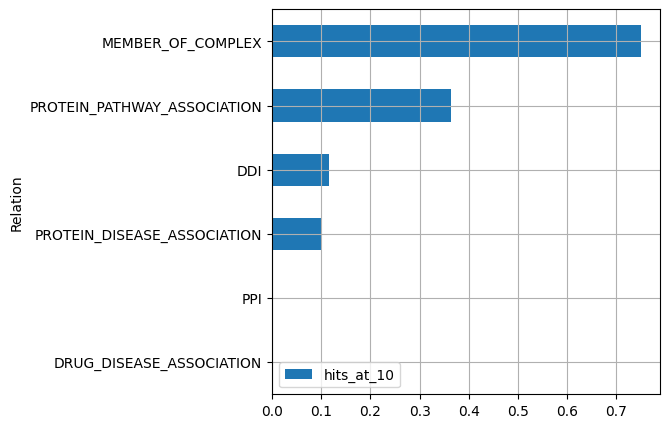

In [34]:
per_relation_plot(results_df, 'hits_at_10')

### Evaluating over specific entity and relation types
The source csv files contain the triples, plus extra information like the types of the entities involved in the triple. We will extract the type information.

We can see that restricting predictions over the correct domain and range of a relation only slightly increases the results.

In [ ]:
can you do an. analysis on degree....
compare rotate to this